In [174]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas
import urllib.request as urllib2
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## Datasets

### [Injuries in CR 2022](https://www.nzip.cz/data/1786-urazy-charakteristika)

### [Population by region in CR 2022](https://csu.gov.cz/produkty/stav-a-pohyb-obyvatelstva-v-cr-rok-2022)

## Extract the data for the year 2022

In [ ]:
year = 2022

injuries_dataset_path = "data/urazy-charakteristika-urazu.csv"
extracted_injuries_path = f"data/injuries-{year}.csv"
chunksize = 10**6

population_dataset_path = f"data/population-{year}.xlsx"

graphs_output_path = "graphs/"

In [166]:
if os.path.isfile(injuries_dataset_path):
    open(extracted_injuries_path, "w+").close()

    with pd.read_csv(injuries_dataset_path, chunksize=chunksize) as reader:
        first = True
        for chunk in reader:
            chunk[chunk["rok"]==year].sort_values(by=["rok", "mesic"]).to_csv(extracted_injuries_path, mode='a', header=first, index=False)
            first=False


C:\Users\adare\AppData\Local\Temp\ipykernel_15184\2134229022.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:
C:\Users\adare\AppData\Local\Temp\ipykernel_15184\2134229022.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:
C:\Users\adare\AppData\Local\Temp\ipykernel_15184\2134229022.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:
C:\Users\adare\AppData\Local\Temp\ipykernel_15184\2134229022.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:
C:\Users\adare\AppData\Local\Temp\ipykernel_15184\2134229022.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader:


In [111]:
injuries = pd.read_csv(extracted_injuries_path).sort_values(by="mesic")
injuries.to_csv(extracted_injuries_path, index=False)

In [112]:
population = pd.read_excel(population_dataset_path)
population = population[["Tab.1.4       ", "Unnamed: 4"]]
population.rename(columns={"Tab.1.4       ": "kraj", "Unnamed: 4": "stred_celkem"}, inplace=True)

## Injuries according to gender and age

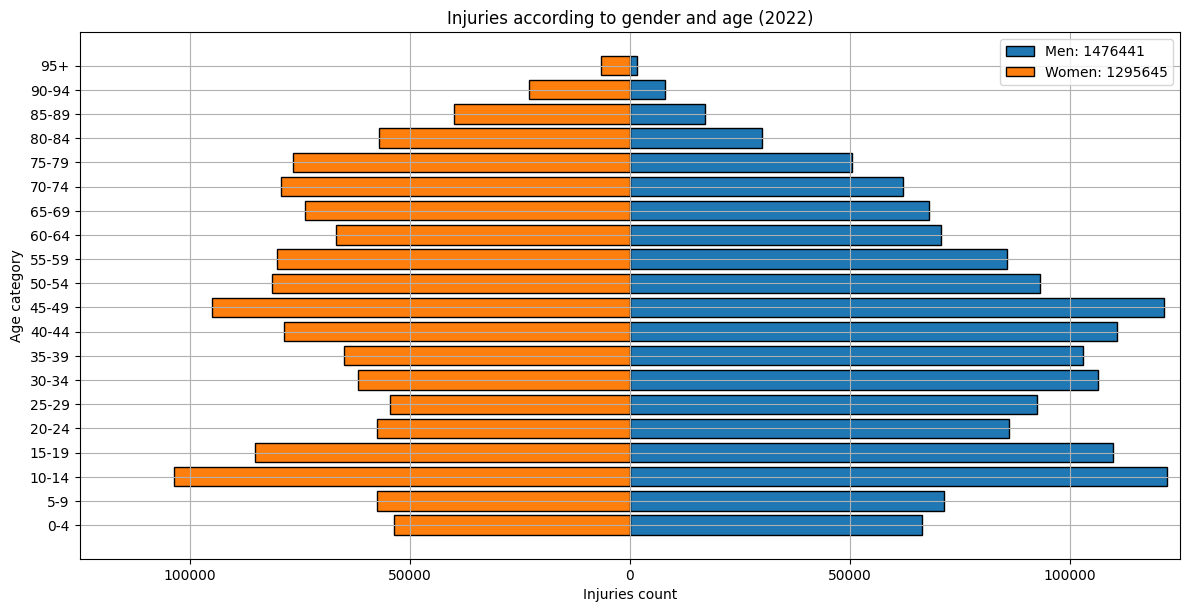

In [157]:
age_groups = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85-89','90-94','95+', 'Unknown']

men_injuries = injuries[injuries['pohlavi']==1]
men_age_injuries = men_injuries.groupby('vek_kat').size()
women_injuries = injuries[injuries['pohlavi']==2]
women_age_injuries = women_injuries.groupby('vek_kat').size()

plt.figure(figsize=(12, 6))

plt.barh(range(20), men_age_injuries, edgecolor='black', label=f'Men: {men_injuries.shape[0]}')
plt.barh(range(20), -women_age_injuries, edgecolor='black', label=f'Women: {women_injuries.shape[0]}')
plt.yticks(range(20), age_groups[:-1])
xticks = plt.xticks()[0]
plt.xticks(ticks=xticks, labels=[abs(int(tick)) for tick in xticks])

plt.xlim((-125_000, 125_000))
plt.ylabel("Age category")
plt.xlabel("Injuries count")
plt.tight_layout()
plt.legend();plt.grid();plt.title(f'Injuries according to gender and age ({year})')
plt.savefig(fname=graphs_output_path+'injuries_by_age_gender.svg', format='svg', bbox_inches='tight')
plt.show()

## Injuries by month

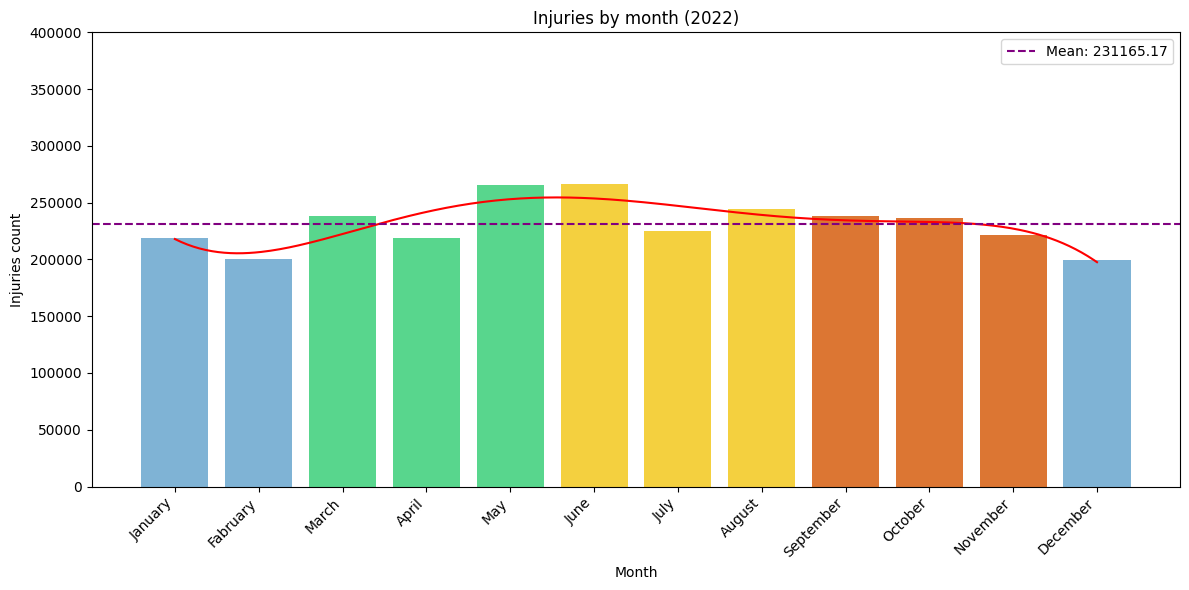

In [159]:
month_injuries = injuries.groupby('mesic').size()

month_names = ["January","Fabruary", "March","April","May","June","July","August","September","October","November","December"]

degree = 5
x = np.array(range(1,13))
coeficients = np.polyfit(x, month_injuries, degree)
poly_function = np.poly1d(coeficients)

x_smooth = np.linspace(1,12,300)
y_smooth = poly_function(x_smooth)

season_colors = {
    'winter': '#7FB3D5',
    'spring': '#58D68D',
    'summer': '#F4D03F',
    'fall': '#DC7633'
}

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

colors = [season_colors[get_season(m)] for m in x]


plt.figure(figsize=(12, 6))

plt.bar(x, month_injuries, tick_label=month_names, color=colors)
plt.plot(x_smooth, y_smooth, color='red')
plt.axhline(month_injuries.mean(), color='purple', linestyle='--', label=f'Mean: {month_injuries.mean():.2f}')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.ylim((0, 400_000))
plt.ylabel("Injuries count")
plt.title(f'Injuries by month ({year})')
plt.tight_layout()
plt.legend()
plt.savefig(fname=graphs_output_path+'injuries_by_month.svg', format='svg', bbox_inches='tight')

plt.show()

## Injuries by region

In [115]:
url='https://raw.githubusercontent.com/Plavit/Simple-Dash-Plotly-Map-Czech-Regions/main/maps/czech-regions-low-res.json'
## Thanks to Plavit https://github.com/Plavit/Simple-Dash-Plotly-Map-Czech-Regions

with urllib2.urlopen(url) as f:
    regions = geopandas.read_file(f)

In [116]:
regions_dict = {"CZ010": "Hlavní město Praha",
"CZ020": "Středočeský kraj",
"CZ031": "Jihočeský kraj",
"CZ032": "Plzeňský kraj",
"CZ041": "Karlovarský kraj",
"CZ042": "Ústecký kraj",
"CZ051": "Liberecký kraj",
"CZ052": "Královéhradecký kraj",
"CZ053": "Pardubický kraj",
"CZ063": "Kraj Vysočina",
"CZ064": "Jihomoravský kraj",
"CZ071": "Olomoucký kraj",
"CZ072": "Zlínský kraj",
"CZ080": "Moravskoslezský kraj",
"CZ099": "Neznámý kraj"}


injuries['kraj_pacient'] = injuries['kraj_pacient'].map(regions_dict)
injuries['kraj_icz'] = injuries['kraj_icz'].map(regions_dict)


In [125]:
injuries_by_region = injuries.groupby(['kraj_pacient']).size().rename("count")
injuries_population_region = pd.merge(injuries_by_region, population, how="left", left_on="kraj_pacient", right_on="kraj")
injuries_population_region['count_per_10000'] = injuries_population_region['count'] // (injuries_population_region['stred_celkem'] // 10_000)
injuries_geom = pd.merge(injuries_population_region, regions, left_on='kraj', right_on='name')
injuries_geom = geopandas.GeoDataFrame(injuries_geom)

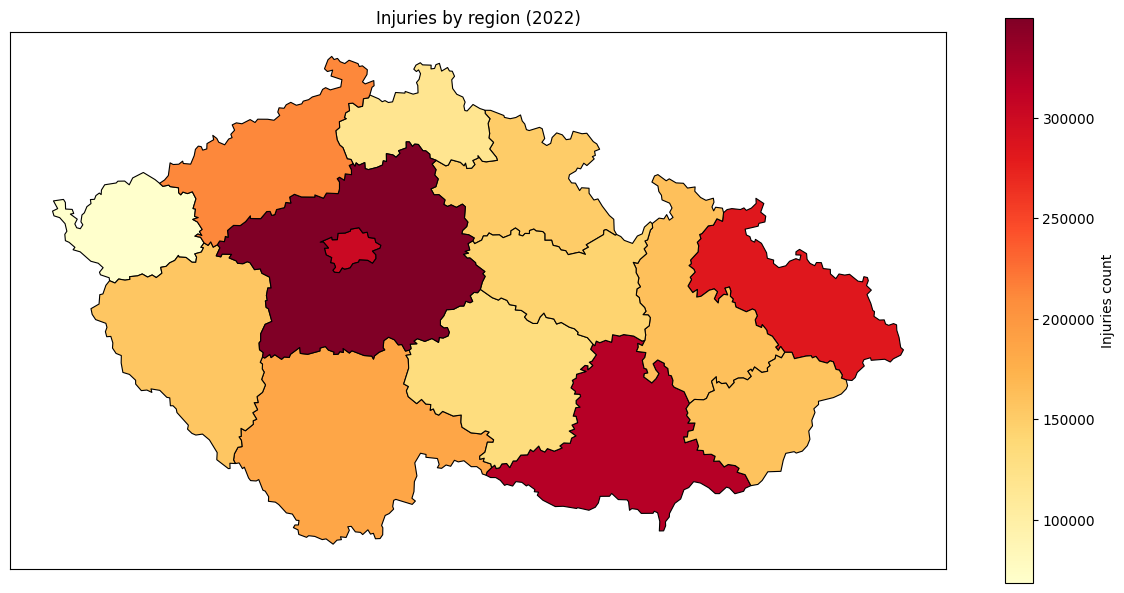

In [126]:
import matplotlib.colors as colors
cmap = plt.cm.YlOrRd

fig, ax = plt.subplots(figsize=(12, 6))

norm = colors.Normalize(
    vmin=injuries_geom['count'].min(),
    vmax=injuries_geom['count'].max()
)
injuries_geom.plot(column='count', cmap=cmap, linewidth=0.8,
                   edgecolor='k', ax=ax, legend=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Injuries count')

ax.set_title(f'Injuries by region ({year})')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig(fname=graphs_output_path+'injuries_by_region.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()

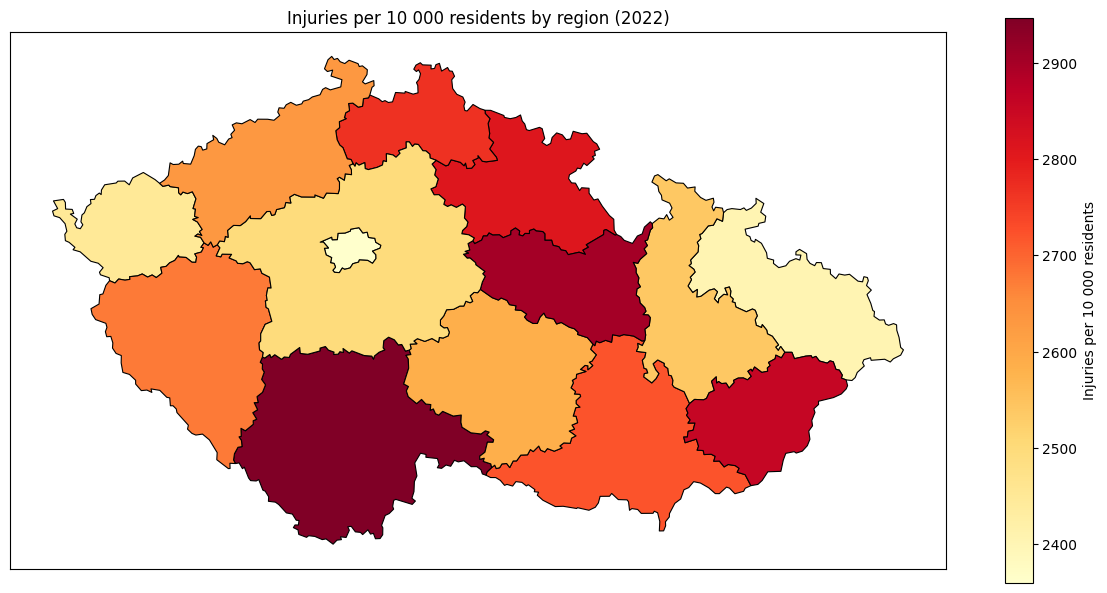

In [127]:


fig, ax = plt.subplots(figsize=(12, 6))

norm = colors.Normalize(
    vmin=injuries_geom['count_per_10000'].min(),
    vmax=injuries_geom['count_per_10000'].max()
)

injuries_geom.plot(column='count_per_10000', cmap=cmap, linewidth=0.8,
                   edgecolor='k', ax=ax, legend=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Injuries per 10 000 residents')

ax.set_title(f'Injuries per 10 000 residents by region ({year})')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig(fname=graphs_output_path+'injuries_by_region_per_residents.svg', format='svg', bbox_inches='tight', transparent=True)
plt.show()

## Falls

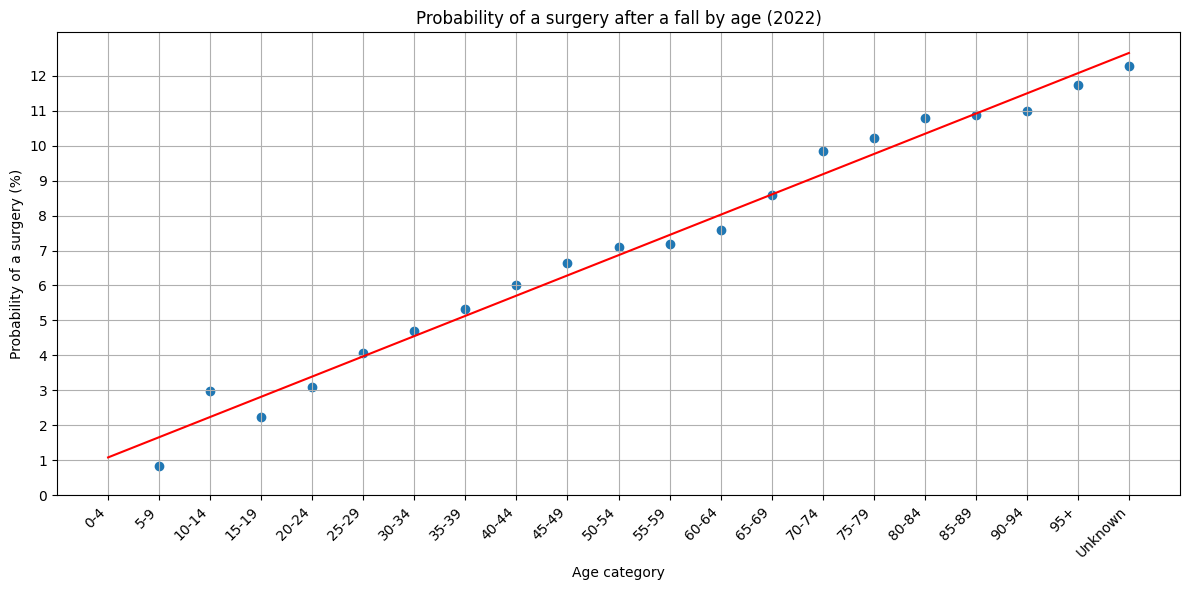

In [120]:
falls = injuries[injuries["pod_kat"]=="W00-W19"]

heavy_falls = falls[falls["operace"]==1]

icu_fall_probability = heavy_falls.shape[0]/falls.shape[0]

surgery_falls_age = heavy_falls.groupby("vek_kat").size()

falls_age = falls.groupby("vek_kat").size()
surgery_probability_age = (surgery_falls_age/falls_age)*100
surgery_probability_age = surgery_probability_age.dropna()

# linear regression
degree = 1
x = np.array(range(len(age_groups)))
coeficients = np.polyfit(surgery_probability_age.index, surgery_probability_age.values, degree)
lin_function = np.poly1d(coeficients)

plt.figure(figsize=(12, 6))

plt.title(f"Probability of a surgery after a fall by age ({year})")
plt.grid(True)
plt.scatter(surgery_probability_age.index, surgery_probability_age.values)
x_line = [0, len(surgery_probability_age.index)]
plt.plot(x_line, lin_function(x_line), color="red")
plt.xticks(x, age_groups,rotation=45)
plt.xlabel("Age category")
plt.yticks(range(13))
plt.ylabel("Probability of a surgery (%)")
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.tight_layout()
plt.savefig(fname=graphs_output_path+'surgery_after_fall.svg', format='svg', bbox_inches='tight')
plt.show()

## Cyclists

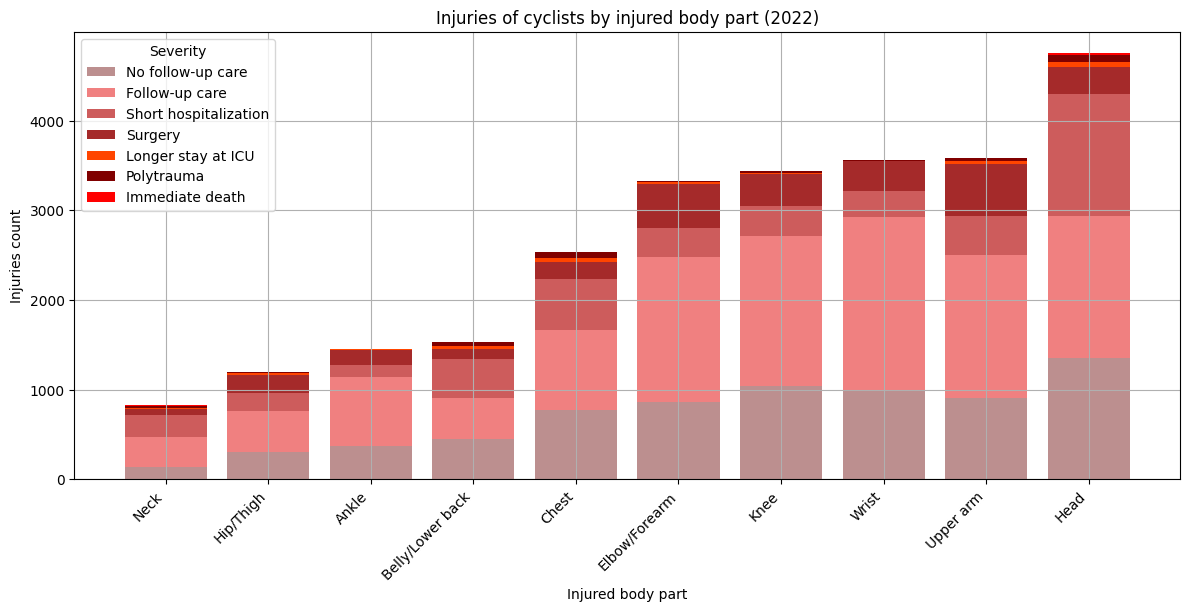

In [121]:
# bikers V20-V29
# cyclists V10-V19
# falls W00-W19
cyclists = injuries[injuries["pod_kat"]=="V10-V19"]
injured_body_part_codes = {'S00_S09': 'Head', 'S10_S19': 'Neck', 'S20_S29': 'Chest',
       'S30_S39': 'Belly/Lower back', 'S40_S49': 'Upper arm', 'S50_S59': 'Elbow/Forearm', 'S60_S69': 'Wrist', 'S70_S79': 'Hip/Thigh', 'S80_S89': 'Knee',
       'S90_S99': 'Ankle'}

severity_types = ['Ia', 'Ib', 'IIa', 'IIb', 'IIc', 'IId', 'IIIc']
severity_descriptions = ['No follow-up care', 'Follow-up care', 'Short hospitalization', 'Surgery', 'Longer stay at ICU', 'Polytrauma', 'Immediate death']
severity_colors = ['rosybrown', 'lightcoral', 'indianred', 'brown', 'orangered', 'maroon', 'red']

cyclists_body_part_injury_counts = {}
for code in injured_body_part_codes:
    cyclists_body_part_injury_counts[code] = cyclists[cyclists[code]==1].shape[0]

# sort counts
sorted_body_part_codes = sorted(cyclists_body_part_injury_counts, key=cyclists_body_part_injury_counts.get)

cyclists_body_part_injury_counts_sorted = {k: cyclists_body_part_injury_counts[k] for k in sorted_body_part_codes}
injured_body_part_codes_sorted = {k: injured_body_part_codes[k] for k in sorted_body_part_codes}

severities = {}
for severity in severity_types:
    severities[severity] = {}
    for code in cyclists_body_part_injury_counts_sorted.keys():
        severities[severity][code] = cyclists[(cyclists[code]==1) & (cyclists['vaznost']==severity)].shape[0]
        cyclists_body_part_injury_counts_sorted[code] += severities[severity][code]


plt.figure(figsize=(12, 6))


bottom = np.array([0 for _ in range(len(injured_body_part_codes_sorted.keys()))])
for severity_code in severities.keys():
    y = np.array(list(severities[severity_code].values()))
    plt.bar(injured_body_part_codes_sorted.keys(), 
            y, 
            bottom=bottom, 
            label=severity_descriptions[severity_types.index(severity_code)], 
            color=severity_colors[severity_types.index(severity_code)])
    bottom = np.add(bottom, y)


plt.legend(title="Severity")
plt.xticks(range(len(injured_body_part_codes_sorted)), injured_body_part_codes_sorted.values(), rotation=45)
plt.xlabel("Injured body part")
plt.ylabel("Injuries count")
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.tight_layout()
plt.grid(True)
plt.title(f"Injuries of cyclists by injured body part ({year})")
plt.savefig(fname=graphs_output_path+'cyclists_injured_body_part.svg', format='svg', bbox_inches='tight')
plt.show()


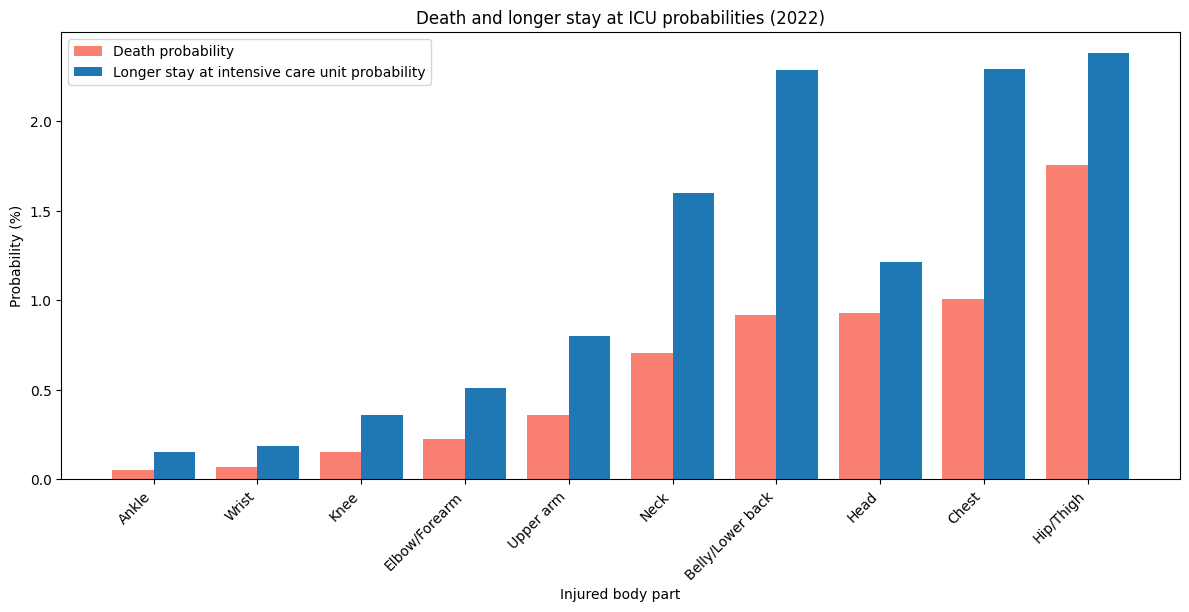

In [153]:
body_part_death_counts = {}
body_part_icu_counts = {}
body_part_death_probabilities = {}
body_part_icu_probabilities = {}

body_part_injuries_counts = {}

for code in injured_body_part_codes:
    code_injuries = injuries[injuries[code]==1]
    body_part_injuries_counts[code] = injuries[injuries[code]==1].shape[0]

    deadly_injuries_code = code_injuries.dropna(subset=["umrti"])

    body_part_death_counts[code] = deadly_injuries_code.shape[0]
    icu_counts = code_injuries[code_injuries["dlouha_jip"]==1]
    body_part_icu_counts[code] = icu_counts.shape[0]

    body_part_death_probabilities[code] = (body_part_death_counts[code] / code_injuries.shape[0])*100
    body_part_icu_probabilities[code] = (body_part_icu_counts[code] / code_injuries.shape[0])*100

# sort probabilities
sorted_body_part_codes = sorted(body_part_death_probabilities, key=body_part_death_probabilities.get)

body_part_death_counts_sorted = {k: body_part_death_probabilities[k] for k in sorted_body_part_codes}
body_part_icu_probabilities_sorted = {k: body_part_icu_probabilities[k] for k in sorted_body_part_codes}
injured_body_part_codes_sorted = {k: injured_body_part_codes[k] for k in sorted_body_part_codes}

width = 0.8
plt.figure(figsize=(12, 6))

plt.bar(body_part_death_counts_sorted.keys(), body_part_death_counts_sorted.values(), color="salmon", label="Death probability", width=width)
plt.bar(body_part_icu_probabilities.keys(), body_part_icu_probabilities.values(), label="Longer stay at intensive care unit probability", width=width/2, align="edge")
plt.xticks(range(len(injured_body_part_codes_sorted)), injured_body_part_codes_sorted.values(), rotation=45)
plt.ylabel("Probability (%)")
plt.xlabel("Injured body part")
plt.tight_layout()
plt.title(f"Death and longer stay at ICU probabilities ({year})")
plt.legend()
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.savefig(fname=graphs_output_path+'death_ICU_probability_by_body_part.svg', format='svg', bbox_inches='tight')

plt.show()

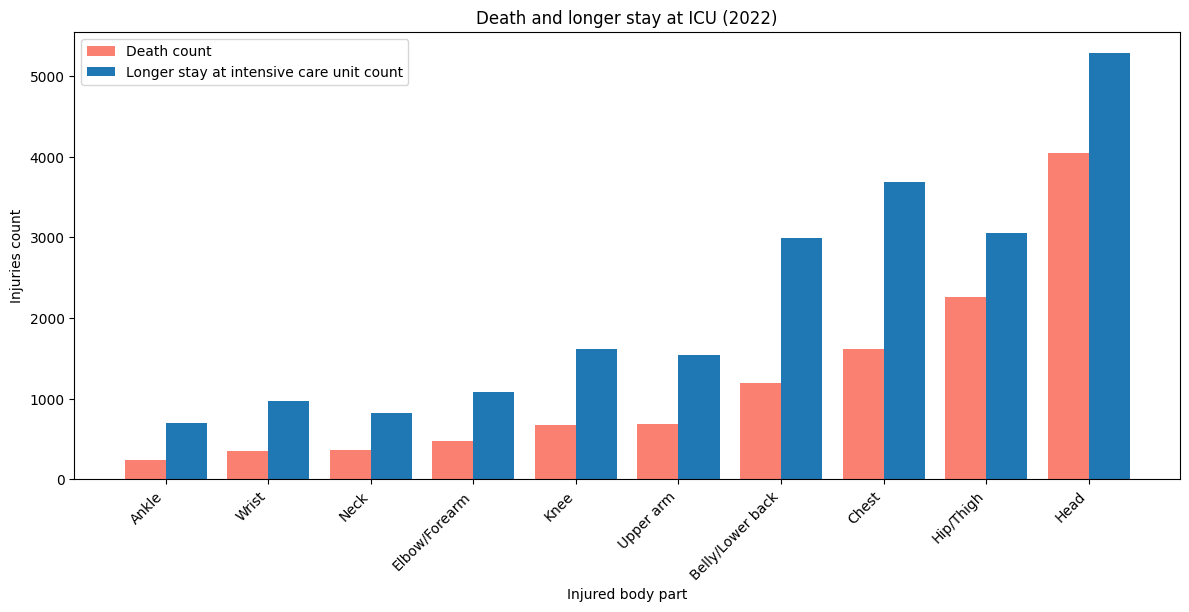

In [154]:
# sort counts
sorted_body_part_codes = sorted(body_part_death_counts, key=body_part_death_counts.get)

body_part_death_counts_sorted = {k: body_part_death_counts[k] for k in sorted_body_part_codes}
body_part_icu_counts_sorted = {k: body_part_icu_counts[k] for k in sorted_body_part_codes}
injured_body_part_codes_sorted = {k: injured_body_part_codes[k] for k in sorted_body_part_codes}
body_part_injuries_counts_sorted = {k: body_part_injuries_counts[k] for k in sorted_body_part_codes}


width = 0.8
plt.figure(figsize=(12, 6))

# plt.bar(body_part_injuries_counts_sorted.keys(), body_part_injuries_counts_sorted.values(), color="purple", label="Total count", width=width)

plt.bar(body_part_death_counts_sorted.keys(), body_part_death_counts_sorted.values(), color="salmon", label="Death count", width=width)
plt.bar(body_part_icu_counts_sorted.keys(), body_part_icu_counts_sorted.values(), label="Longer stay at intensive care unit count", width=width/2, align="edge")

plt.xticks(range(len(injured_body_part_codes_sorted)), injured_body_part_codes_sorted.values(), rotation=45)
plt.ylabel("Injuries count")
plt.xlabel("Injured body part")
plt.tight_layout()
plt.title(f"Death and longer stay at ICU ({year})")
plt.legend()
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.savefig(fname=graphs_output_path+'death_ICU_by_body_part.svg', format='svg', bbox_inches='tight')

plt.show()


## Traffic accidents by age

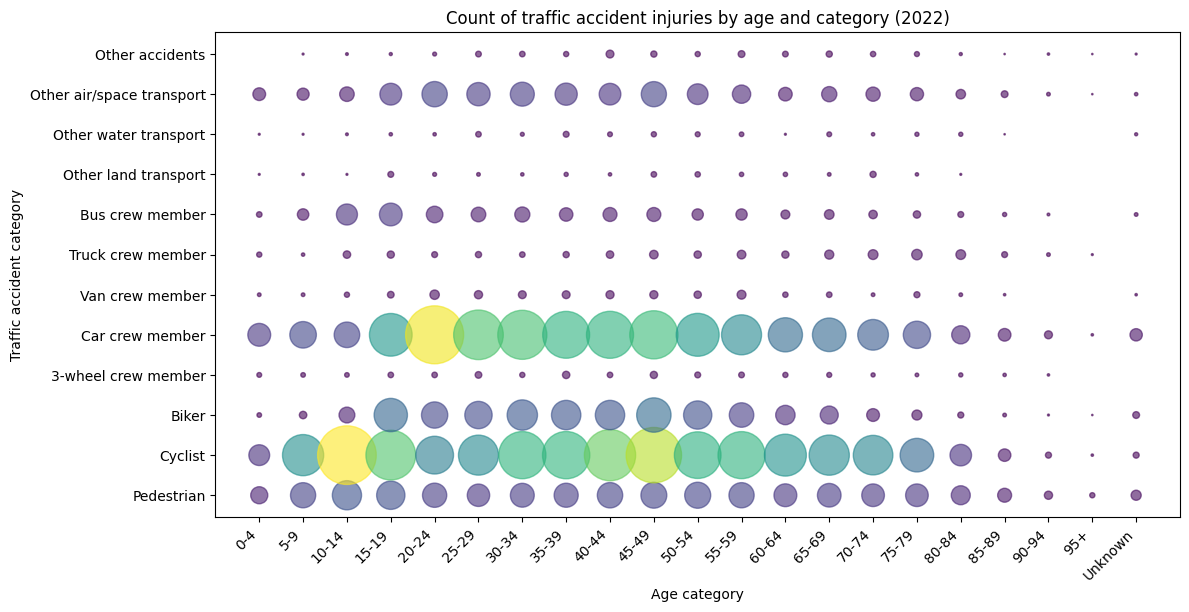

In [124]:
accident_category = ["Pedestrian", 
                     "Cyclist", 
                     "Biker", 
                     "3-wheel crew member", 
                     "Car crew member", 
                     "Van crew member", 
                     "Truck crew member", 
                     "Bus crew member", 
                     "Other land transport", 
                     "Other water transport", 
                     "Other air/space transport",
                     "Other accidents"]

pod_kat_dropna=injuries.dropna(subset=['pod_kat'])
traffic_accidents = pod_kat_dropna[pod_kat_dropna['pod_kat'].str.contains('V')]

traffic_accidents_age = traffic_accidents.groupby(['vek_kat', 'pod_kat']).size()

x = np.array(range(len(age_groups)))

df = traffic_accidents_age.reset_index(name='count')
x_labels = df['vek_kat'].unique()
y_labels = df['pod_kat'].unique()

x_mapping = {label: i for i, label in enumerate(x_labels)}
y_mapping = {label: i for i, label in enumerate(y_labels)}

x = df['vek_kat'].map(x_mapping)
y = df['pod_kat'].map(y_mapping)
sizes = df['count'] 

plt.figure(figsize=(12, 6))
plt.scatter(x, y, s=sizes, c=sizes, alpha=0.6)

plt.xticks(ticks=list(x_mapping.values()), labels=age_groups, rotation=45)
plt.setp(plt.gca().get_xticklabels(), ha='right')
plt.yticks(ticks=list(y_mapping.values()), labels=accident_category)

plt.xlabel('Age category')
plt.ylabel('Traffic accident category')
plt.tight_layout()
plt.title(f'Count of traffic accident injuries by age and category ({year})')
plt.savefig(fname=graphs_output_path+'traffic_accidents.svg', format='svg', bbox_inches='tight')

plt.show()

## K-Means Clustering

In [280]:
injuries_encoded = pd.get_dummies(injuries.drop(["kraj_icz"], axis=1))

scaler = StandardScaler()
injuries_scaled = scaler.fit_transform(injuries_encoded)

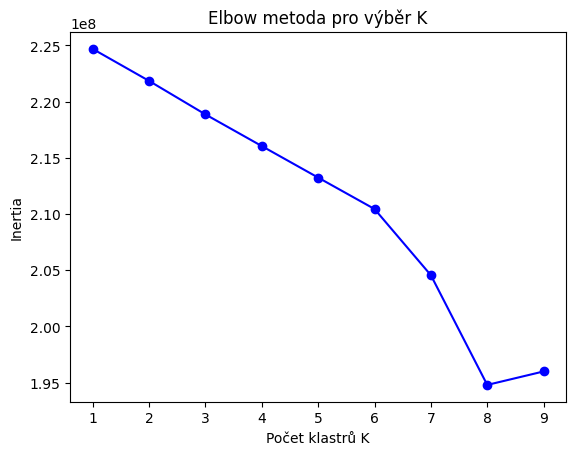

In [180]:
inertia = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(injuries_scaled)
    inertia.append(km.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Počet klastrů K')
plt.ylabel('Inertia')
plt.title('Elbow metoda pro výběr K')
plt.show()

In [276]:
kmeans = KMeans(n_clusters=3, random_state=79)
kmeans.fit(injuries_scaled)
pca = PCA(n_components=2)
injuries_2d = pca.fit_transform(injuries_scaled)


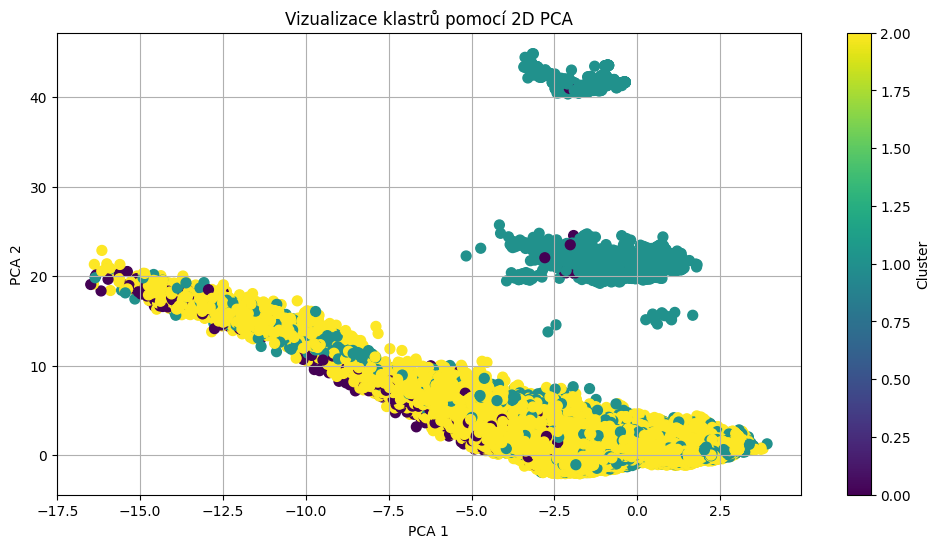

In [258]:


plt.figure(figsize=(12, 6))
plt.scatter(injuries_2d[:, 0], injuries_2d[:, 1], c=kmeans.labels_, s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Vizualizace klastrů pomocí 2D PCA')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

C:\Users\adare\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


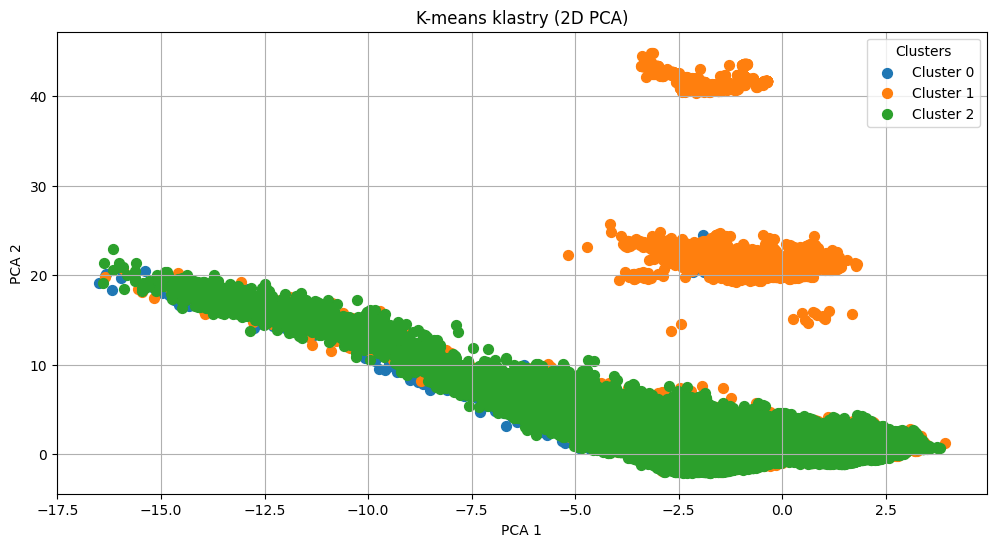

In [259]:
labels = kmeans.labels_
unique_clusters = np.unique(labels)

plt.figure(figsize=(12, 6))

for cluster in unique_clusters:
    mask = labels == cluster
    plt.scatter(
        injuries_2d[mask, 0], 
        injuries_2d[mask, 1], 
        label=f'Cluster {cluster}', 
        s=50
    )

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('K-means klastry (2D PCA)')
plt.legend(title='Clusters')
plt.grid(True)
plt.show()

In [260]:
age_map = {
    1: 2,
    2: 7,
    3: 12,
    4: 17,
    5: 22,
    6: 27,
    7: 32,
    8: 37,
    9: 42,
    10: 47,
    11: 52,
    12: 57,
    13: 62,
    14: 67,
    15: 72,
    16: 77,
    17: 82,
    18: 87,
    19: 92,
    20: 97,
    99: 47
}

In [278]:
injuries['cluster'] = kmeans.labels_
injuries['age_group_avg'] = injuries['vek_kat'].dropna().map(age_map)
cluster_data = injuries.groupby('cluster').agg({
    'age_group_avg': 'mean',
    'kraj_pacient': lambda x: x.mode().iloc[0],
    'pohlavi': lambda x: x.mode().iloc[0],
    'vaznost': lambda x: x.mode().iloc[0]
    })
# category_value_counts = injuries.groupby('cluster')['pod_kat'].value_counts(normalize=True)*100

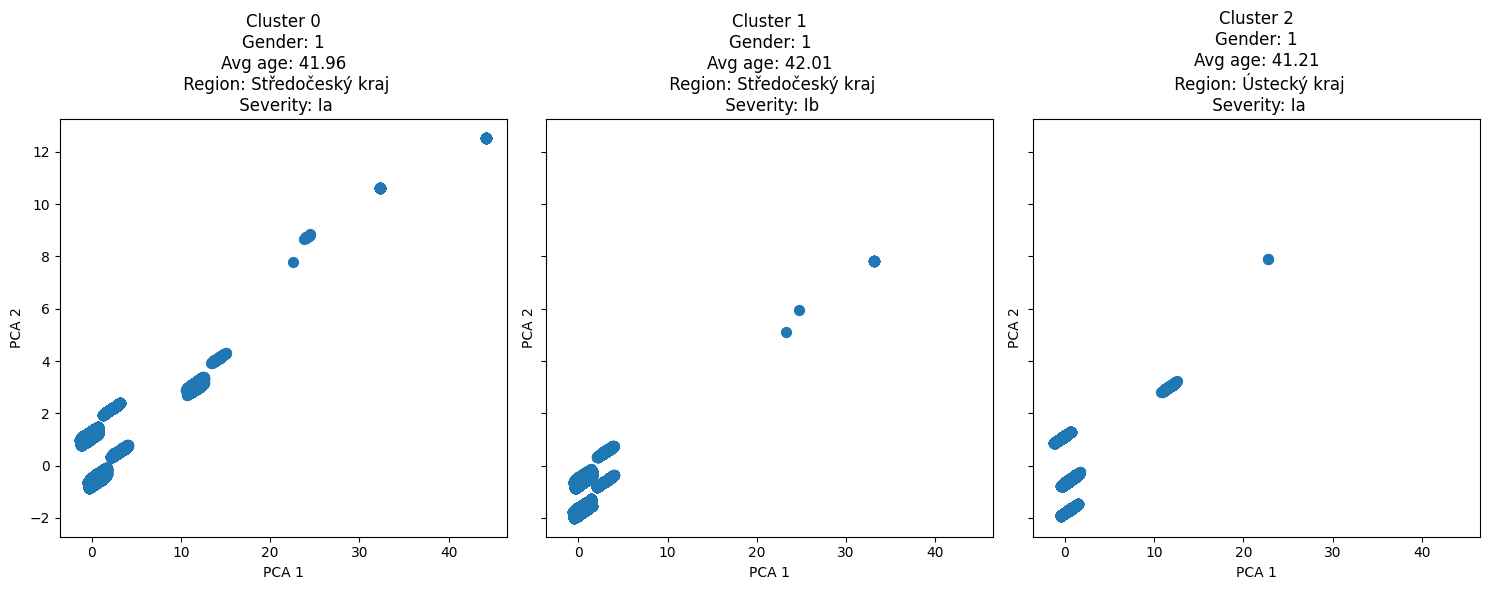

In [279]:
labels = kmeans.labels_
unique_clusters = np.unique(labels)
n_clusters = len(unique_clusters)

fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 6), sharex=True, sharey=True)

if n_clusters == 1:
    axes = [axes]

for i, cluster in enumerate(unique_clusters):
    mask = labels == cluster
    row = i
    column = i%4
    axes[row].scatter(injuries_2d[mask, 0], injuries_2d[mask, 1], s=50)
    axes[row].set_title(f'Cluster {cluster}\nGender: {cluster_data['pohlavi'][cluster]}\nAvg age: {cluster_data['age_group_avg'][cluster]:.2f}\n Region: {cluster_data['kraj_pacient'][cluster]}\n Severity: {cluster_data['vaznost'][cluster]}')#\n Falls: {category_value_counts[cluster]['W00-W19']:.2f}% \n Pedestrians: {category_value_counts[cluster]['V01-V09']:.2f}%\n Cyclists: {category_value_counts[cluster]['V10-V19']:.2f}%\n Car crew members: {category_value_counts[cluster]['V40-V49']:.2f}')
    axes[row].set_xlabel('PCA 1')
    axes[row].set_ylabel('PCA 2')

plt.tight_layout()
plt.show()